In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
import scikitplot

In [ ]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/EMOCNN/fer2013.csv')


In [ ]:
(train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index().T

,0,1,2,3,4,5,6
emotion,0.138017,0.015242,0.142698,0.250481,0.169337,0.111517,0.172709


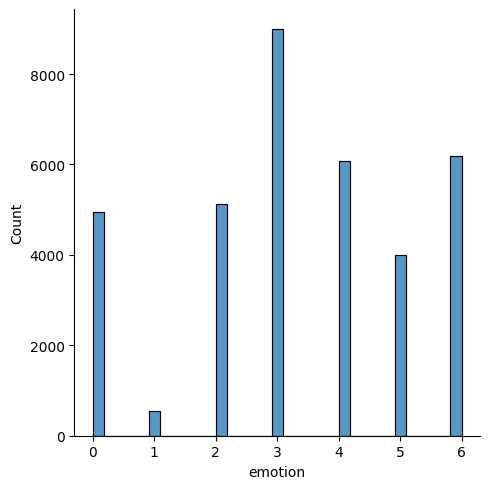

In [ ]:
sns.displot(train_df, x=train_df.emotion)


In [ ]:
emotion_label = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

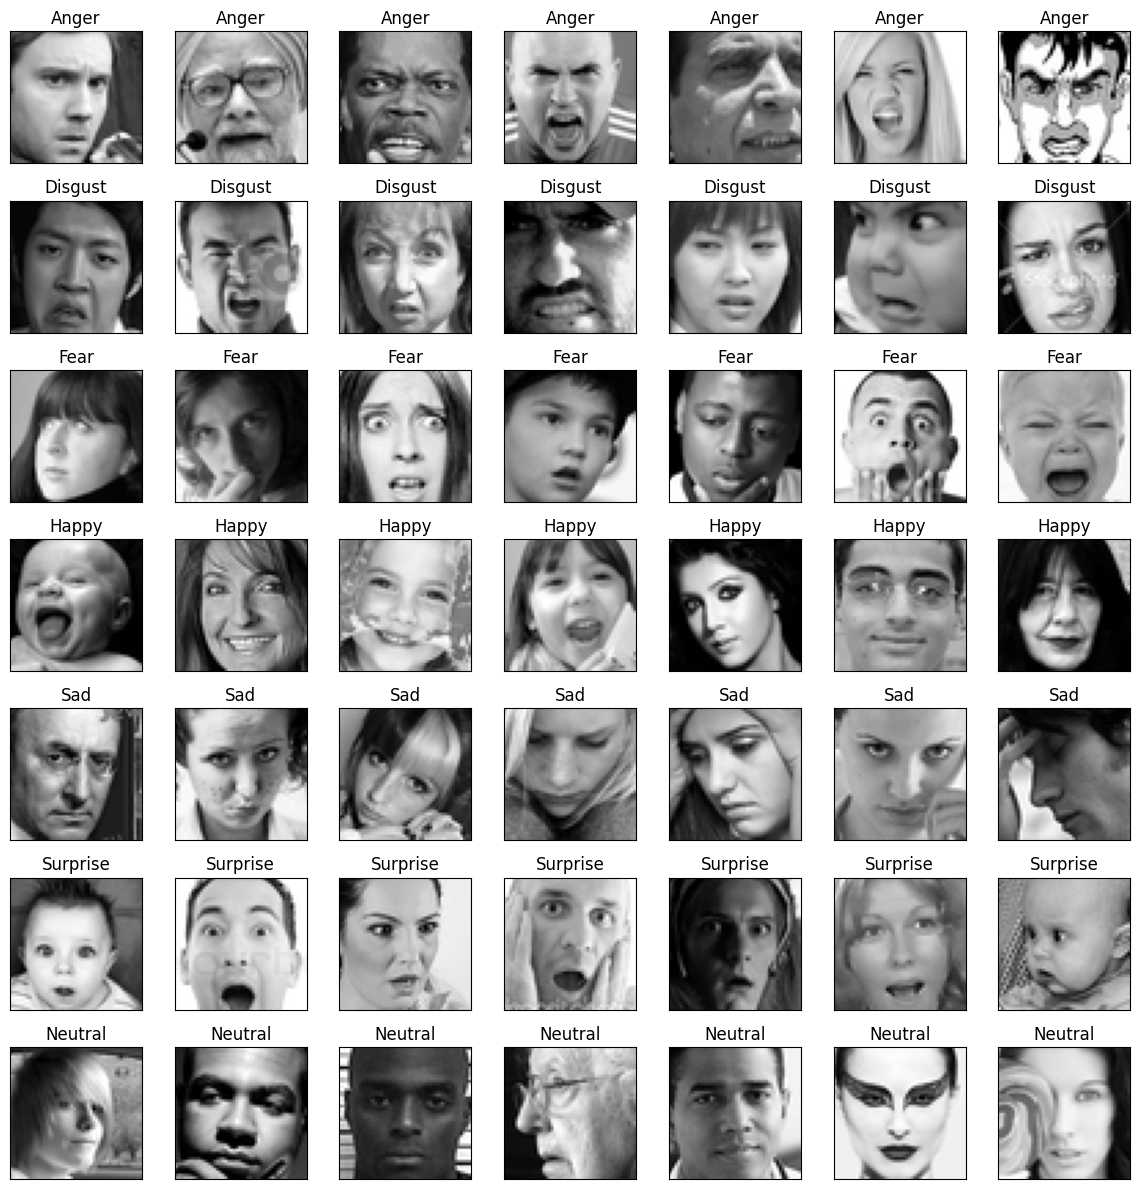

In [ ]:
fig = plt.figure(1, (12,12))
k=0

for label in sorted(train_df.emotion.unique()):
    for j in range(7):
        px = train_df[train_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

In [ ]:
train_df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train_df['pixels']]
img_array = np.concatenate(train_df.pixels)

le = LabelEncoder()
#One-hit-encoded labels
img_labels = le.fit_transform(train_df.emotion)
img_labels = np_utils.to_categorical(img_labels)
print('Pixel Shape: ', img_array.shape)
print('Label Shape: ', img_labels.shape)


Pixel Shape:  (35887, 48, 48, 1)
Label Shape:  (35887, 7)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=1)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(28709, 48, 48, 1) (7178, 48, 48, 1) (28709, 7) (7178, 7)


In [ ]:
Xs_train = X_train / 255
Xs_valid = X_valid / 255

In [ ]:
#Used for Model
X_train_color = np.repeat(Xs_train, repeats=3, axis=3)
X_valid_color = np.repeat(Xs_valid, repeats=3, axis=3)
print(X_train_color.shape)
print(X_valid_color.shape)

(28709, 48, 48, 3)
(7178, 48, 48, 3)


58889256/58889256 [==============================] - 1s 0us/step


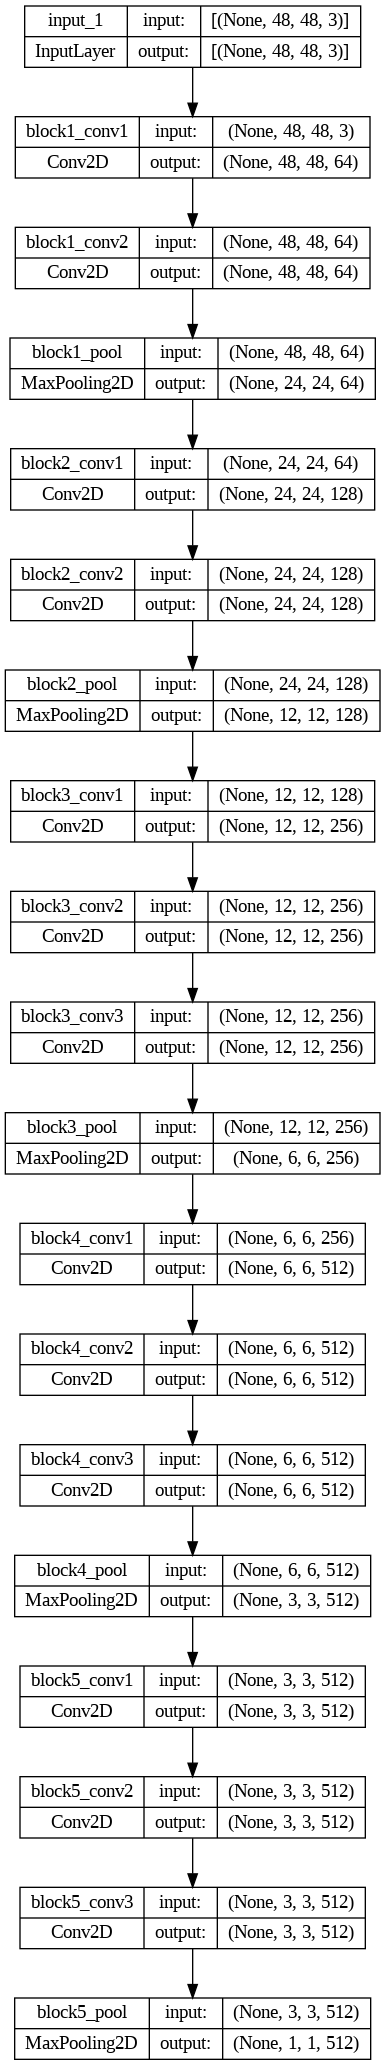

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 3), 
    include_top = False, 
    weights = 'imagenet'
)

#Start with a non trainable model
base_model.trainable = False

tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
np.random.seed(7)
tf.random.set_seed(7)

cnn = Sequential ([
    base_model,
    

    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.15),
    Dense(7, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.000001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [ ]:
h1 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=100,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/100
448/448 [==============================] - 52s 74ms/step - loss: 1.9683 - accuracy: 0.1825 - val_loss: 1.8902 - val_accuracy: 0.2565
Epoch 2/100
448/448 [==============================] - 31s 69ms/step - loss: 1.9026 - accuracy: 0.2141 - val_loss: 1.8540 - val_accuracy: 0.2687
Epoch 3/100
448/448 [==============================] - 31s 69ms/step - loss: 1.8712 - accuracy: 0.2316 - val_loss: 1.8140 - val_accuracy: 0.2934
Epoch 4/100
448/448 [==============================] - 31s 68ms/step - loss: 1.8419 - accuracy: 0.2496 - val_loss: 1.7692 - val_accuracy: 0.3073
Epoch 5/100
448/448 [==============================] - 31s 70ms/step - loss: 1.8107 - accuracy: 0.2621 - val_loss: 1.7286 - val_accuracy: 0.3203
Epoch 6/100
448/448 [==============================] - 31s 68ms/step - loss: 1.7838 - accuracy: 0.2757 - val_loss: 1.6923 - val_accuracy: 0.3266
Epoch 7/100
448/448 [==============================] - 31s 69ms/step - loss: 1.7566 - accuracy: 0.2960 - val_loss: 1.6724 - val_ac

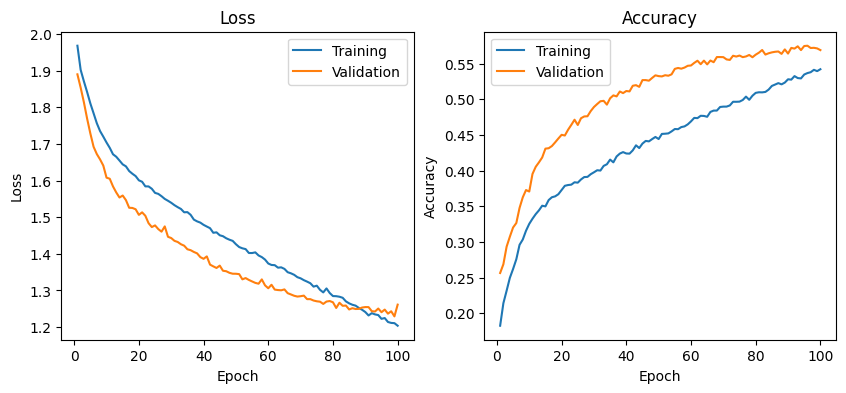

In [ ]:
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
h1 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=20,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/20
448/448 [==============================] - 32s 70ms/step - loss: 1.1993 - accuracy: 0.5436 - val_loss: 1.2282 - val_accuracy: 0.5789
Epoch 2/20
448/448 [==============================] - 31s 68ms/step - loss: 1.1962 - accuracy: 0.5460 - val_loss: 1.2377 - val_accuracy: 0.5750
Epoch 3/20
448/448 [==============================] - 32s 71ms/step - loss: 1.1899 - accuracy: 0.5501 - val_loss: 1.2353 - val_accuracy: 0.5723
Epoch 4/20
448/448 [==============================] - 31s 69ms/step - loss: 1.1873 - accuracy: 0.5498 - val_loss: 1.2315 - val_accuracy: 0.5825
Epoch 5/20
448/448 [==============================] - 30s 68ms/step - loss: 1.1810 - accuracy: 0.5516 - val_loss: 1.2525 - val_accuracy: 0.5726
Epoch 6/20
448/448 [==============================] - 30s 68ms/step - loss: 1.1772 - accuracy: 0.5565 - val_loss: 1.2291 - val_accuracy: 0.5822
Epoch 7/20
448/448 [==============================] - 31s 68ms/step - loss: 1.1679 - accuracy: 0.5594 - val_loss: 1.2279 - val_accuracy:

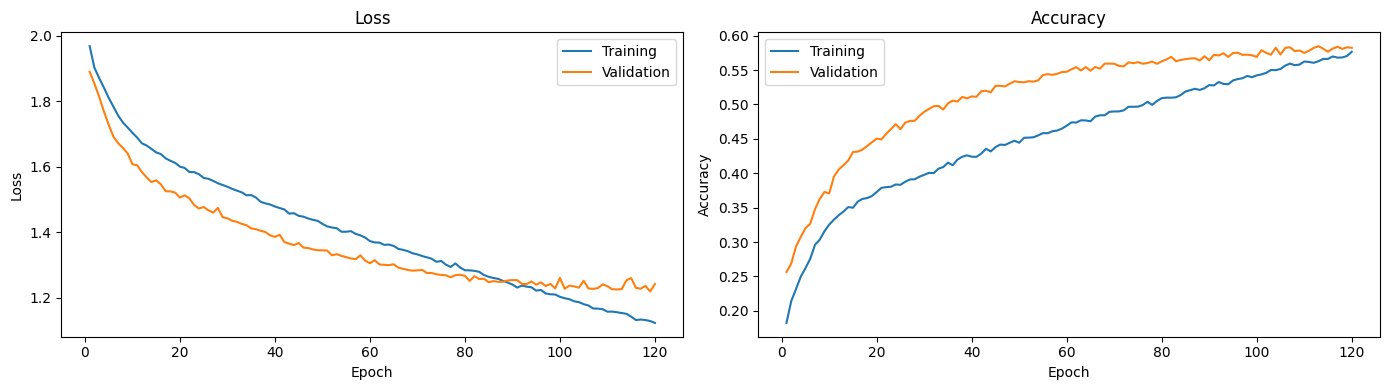

In [ ]:
for k in history.keys():
    history[k] += h1.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
cnn.save(f'/content/drive/MyDrive/EMOCNN/FER_VGG16.h5')
pickle.dump(history, open(f'/content/drive/MyDrive/EMOCNN/FER_VGG16_history.pkl', 'wb'))